In [8]:

import matplotlib
import matplotlib.pyplot as plt
from typing import Tuple
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    average_precision_score,
    log_loss,
    precision_recall_curve,
    precision_recall_fscore_support,
)
from sklearn.metrics import (
    roc_curve, roc_auc_score 
)
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.preprocessing import StandardScaler

In [9]:
RUTE = Path("../../../data").resolve()
FEATURE_FRAME_CSV = RUTE / Path("feature_frame.csv")

In [10]:
feature_frame = pd.read_csv(FEATURE_FRAME_CSV)

In [11]:
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = ["outcome"]

features_cols = [col for col in feature_frame.columns if col not in info_cols + label_col]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]

numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [12]:
def push_relevant_dataframe (df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame: 
    """We are only interested in big enough orders that are profitable"""
    order_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = order_size [order_size >= min_products].index 
    return df.loc[lambda x: x.order_id.isin (orders_of_min_size)]

df = (
    feature_frame.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime (x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

In [13]:
df["outcome"].value_counts(normalize=True)

outcome
0.0    0.985522
1.0    0.014478
Name: proportion, dtype: float64

- Problema muy desbalanceado

In [14]:
outcome_frequency_in_orders = df.groupby('order_id')['outcome'].value_counts().unstack(fill_value=0)

outcome_proportion = outcome_frequency_in_orders[0] / outcome_frequency_in_orders[1]

mean_ratio = outcome_proportion.mean()

print(f"The average number of 0 for every 1 is: {mean_ratio}")

The average number of 0 for every 1 is: 83.62571996389401



### Project
Project focuses on model training, so we are NOT developing any new features like: item global popularity or item popularity for individual users at each time step.


### Data splits
#### In this section we will be spliting the data in 3 groups:
    - Training: to fit our models
    - Validation: to pick best model and hyperparametrisation. In addition, to perform calibration.
    - Test: to evaluate the final model performance.
From product definition in the Product Requirements Document (PRD) we are only interested in orders with at least 5 items in the basket:

In [15]:
daily_orders = df.groupby("order_date").order_id.nunique()
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

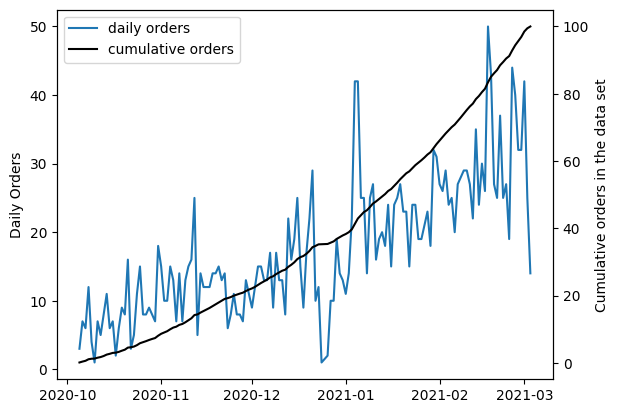

In [16]:

fig, ax = plt.subplots()
lns1 = ax.plot(daily_orders, label="daily orders")
axi = ax.twinx()
lns2 = axi.plot(cumsum_daily_orders*100, color="k", label="cumulative orders") 
ax.set_ylabel("Daily Orders")
axi.set_ylabel("Cumulative orders in the data set")
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

-  Hay un cambio en la distribución a lo largo del tiempo (se multiplican por 4 las ventas). El negocio está creciendo con nuevos clientes, que tendrán distintos patrones que los anteriores, teniéndose que reflejar en los modelos.
-  Por lo tanto, haremos un temporal split para que nuestros campos de entrenamiento, validación y test reflejen ese cambio en el negocio

In [17]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
train_val_cutoff = cumsum_daily_orders [cumsum_daily_orders <= 0.7].idxmax() 
val_test_cutoff = cumsum_daily_orders [cumsum_daily_orders <= 0.9].idxmax()

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


- Al quedarte con el 70% de las orders y no de las filas, te aseguras que no queda ninguna order en dos conjuntos distintos, haciendo un data leakage
- Entrenas con 4 meses de datos, pero valido con solo 18 días, y hago test con 9 días.
- Aunque haga test con tan pocos días, no hay ningún día especial a finales de febrero, y además se recoge un ciclo de una semana

In [18]:
train_df = df[df.order_date <= train_val_cutoff]
val_df = df[
    (df.order_date > train_val_cutoff)
    & (df.order_date <= val_test_cutoff)
]
test_df = df[df.order_date > val_test_cutoff]

- Haciendo un cross validation con global popularity, se haría un data leakage porque validarías con datos del futuro en los que verías que el producto tiene más popularidad porque se ha vendido mucho

In [19]:
def plot_metrics( 
    model_name: str, 
    y_pred: pd.Series, 
    y_test: pd.Series,
    target_precision: float = 0.05,
    figure: Tuple [matplotlib.figure. Figure, np.array] = None,
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred) 
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score (y_test, y_pred)
    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure

    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall Curve")
    ax[0].legend()
    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

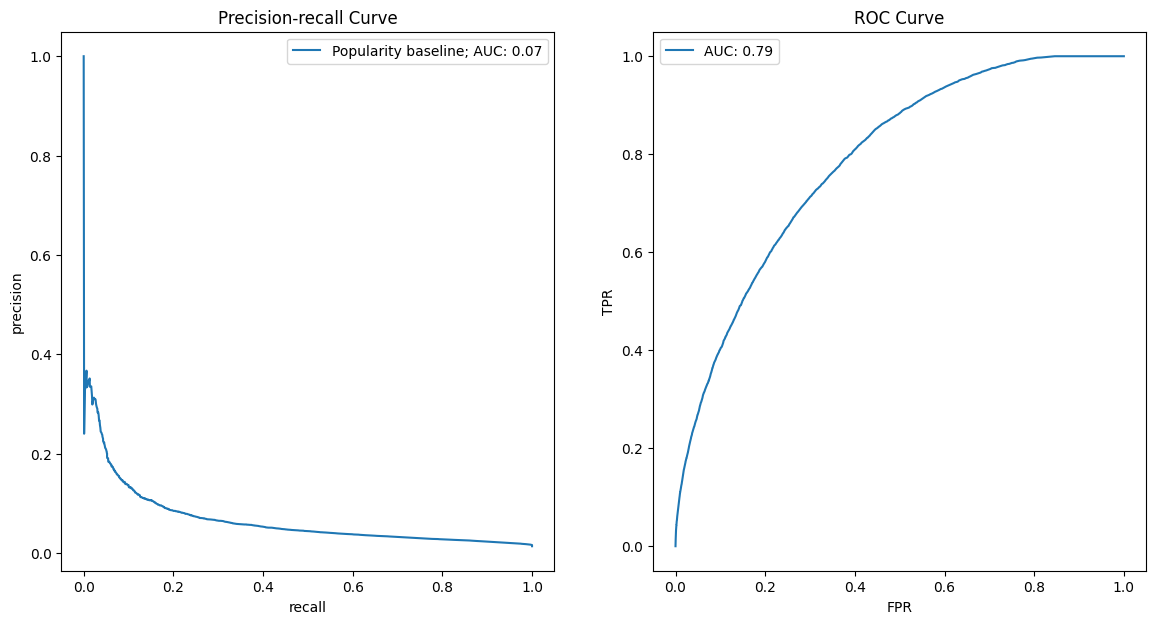

In [20]:
plot_metrics(
    "Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col]
)

- Al ver la curva puedes decidir en que punto trabajar
- En problemas tan desbalanceados con un 98% de una misma clase, el accuracy siempre va a ser muy alto porque simplemente podrías decidir que el 100% es de esa clase y acertarías el 98%, pero sin embargo, no estarías prediciendo nada
- En estos problemas es esencial ver la curva para comprobar el funcionamiento del modelo
- Interpretación area por debajo de la curva roc: Si yo tomo dos valores predichos por el modelo, y uno más score que otro, ¿cuál es la probabilidad de que uno sea 1, y otro sea 0?

In [21]:

columns = [
    "ordered_before",
    "abandoned_before",
    "normalised_price",
    "set_as_regular",
    "active_snoozed",
    "discount_pct",
    "days_since_purchase_variant_id",
    "avg_days_to_buy_variant_id", 
    "std_days_to_buy_variant_id",
    "days_since_purchase_product_type",
    "avg_days_to_buy_product_type",
    "std_days_to_buy_product_type",
    "global_popularity",
    "people_ex_baby",
    "count_adults",
    "count_children",
    "count_babies",
    "count_pets",
    "user_order_seq"
]

In [22]:
def evaluate_configuration(
    clf,
    X_train,
    y_train,
    X_val,
    y_val,
    train_aucs_list,
    val_aucs_list,
    train_ce_list,
    val_ce_list,
    train_aps_list,
    val_aps_list,
):
    val_preds = clf.predict_proba(X_val)[:, 1]
    train_preds = clf.predict_proba(X_train)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_preds)
    val_auc = roc_auc_score(y_val, val_preds)

    train_crossentropy = log_loss(y_train, train_preds)
    val_crossentropy = log_loss(y_val, val_preds)

    train_ap = average_precision_score(y_train, train_preds)
    val_ap = average_precision_score(y_val, val_preds)

    train_aucs_list.append(train_auc)
    val_aucs_list.append(val_auc)
    train_ce_list.append(train_crossentropy)
    val_ce_list.append(val_crossentropy)
    train_aps_list.append(train_ap)
    val_aps_list.append(val_ap)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(clf, columns):
    fig, ax = plt.subplots()

    fi = pd.DataFrame(
        list(zip(columns, clf.feature_importances_)), columns=["features", "importance"]
    ).sort_values(by="importance", ascending=True)

    fi.plot(kind="barh", x="features", y="importance", ax=ax)
    
    return fi, fig, ax

### Linear models

In [24]:
def feature_label_split(df: pd.DataFrame, label_col: str )-> Tuple [pd.DataFrame, pd. Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

In [25]:
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []
lr_push_train_aps = []
lr_push_val_aps = []

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]
for c in cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=c if c else 1.0) 
    )
    lr.fit(X_train[columns], y_train)
    evaluate_configuration(
        lr,
        X_train[columns],
        y_train,
        X_val[columns],
        y_val,
        lr_push_train_aucs,
        lr_push_val_aucs,
        lr_push_train_ce,
        lr_push_val_ce,
        lr_push_train_aps,
        lr_push_val_aps,
    )

    print(
        f"C: {c} done with train aucs {lr_push_train_aucs[-1]:.4f} and val aucs {lr_push_val_aucs[-1]:.4f}. "
        f"AP train: {lr_push_train_aps[-1]:.4f} and val: {lr_push_val_aps[-1]:.4f}. "
        f"Cross entropy train: {lr_push_train_ce[-1]:.4f}, val: {lr_push_val_ce[-1]:.4f}."
    )

C: 1e-08 done with train aucs 0.8247 and val aucs 0.8318. AP train: 0.1560 and val: 0.1602. Cross entropy train: 0.0782, val: 0.0717.
C: 1e-06 done with train aucs 0.8254 and val aucs 0.8326. AP train: 0.1562 and val: 0.1603. Cross entropy train: 0.0762, val: 0.0694.
C: 0.0001 done with train aucs 0.8142 and val aucs 0.8248. AP train: 0.1599 and val: 0.1588. Cross entropy train: 0.0665, val: 0.0604.
C: 0.01 done with train aucs 0.8007 and val aucs 0.8138. AP train: 0.1581 and val: 0.1561. Cross entropy train: 0.0663, val: 0.0603.
C: 1 done with train aucs 0.8003 and val aucs 0.8136. AP train: 0.1581 and val: 0.1561. Cross entropy train: 0.0663, val: 0.0603.
C: 100 done with train aucs 0.8003 and val aucs 0.8136. AP train: 0.1581 and val: 0.1561. Cross entropy train: 0.0663, val: 0.0603.
C: 10000.0 done with train aucs 0.8003 and val aucs 0.8136. AP train: 0.1581 and val: 0.1561. Cross entropy train: 0.0663, val: 0.0603.
C: None done with train aucs 0.8003 and val aucs 0.8136. AP train:

- Después de la observación en el module_3 con Lasso y Ridge, vemos que con Lasso se pone mucha importancia a las 3 columnas únicamente y lleva el resto a 0. Además, esas mismas 3 columnas son las que se toma más importancia en Ridge.
- Para llegar a esta conclusión es muy importante ver la importancia habiendo normalizado los coeficientes previamente

In [26]:
reduced_cols = ["ordered_before", "abandoned_before", "global_popularity", "set_as_regular"]


## Non linear models
- We seek now to improve the complexity of our model to try to boost performance.
- We will be exploring some examples of non linear models to show how to play with them as an exercise.

### Random forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

n_trees_grid = [5, 25, 50, 100]

rf_push_train_aucs = []
rf_push_val_aucs = []
rf_push_train_ce = []
rf_push_val_ce = []
rf_push_train_aps = []
rf_push_val_aps = []

for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_train[columns], y_train)
    evaluate_configuration(
        rf,
        X_train[columns],
        y_train,
        X_val[columns],
        y_val,
        rf_push_train_aucs,
        rf_push_val_aucs,
        rf_push_train_ce,
        rf_push_val_ce,
        rf_push_train_aps,
        rf_push_val_aps,
    )

    print(
        f"# Trees: {n_trees} done with train auc: {rf_push_train_aucs[-1]:.4f} and val auc: {rf_push_val_aucs[-1]:.4f} "
        f"AP train: {rf_push_train_aps[-1]:.4f} and val: {rf_push_val_aps[-1]:.4f}. "
        f"Cross entropy train: {rf_push_train_ce[-1]:.4f}, val: {rf_push_val_ce[-1]:.4f}"
    )

# Trees: 5 done with train auc: 0.9903 and val auc: 0.6474 AP train: 0.7701 and val: 0.0698. Cross entropy train: 0.0248, val: 0.3450
# Trees: 25 done with train auc: 0.9952 and val auc: 0.7154 AP train: 0.8525 and val: 0.1122. Cross entropy train: 0.0209, val: 0.2482
# Trees: 50 done with train auc: 0.9955 and val auc: 0.7362 AP train: 0.8596 and val: 0.1195. Cross entropy train: 0.0208, val: 0.2157
# Trees: 100 done with train auc: 0.9957 and val auc: 0.7532 AP train: 0.8628 and val: 0.1251. Cross entropy train: 0.0207, val: 0.1844


- El error de entrenamiento en Random Forest no es 0 porque siempre algún árbol no va a ser independiente, no reduciendo así el error de varianza a 0
- Random forest with few trees is performing poorly (val auc) --> probably it is suffering from variance and we need to decorrelate further the predictions by adding more trees.
- Random forest funciona con bagging en el que si tenemos muchos clasificadores independientes, la media de ellos reducirá el error de varianza. Si además se llega hasta el final del árbol en cada uno de ellos, se reducirá el error de sesgo.
- Si vemos el val auc, no tendría sentido probar con 200 árboles
- El val ap es mayor con los modelos lineales ya que es 0.16

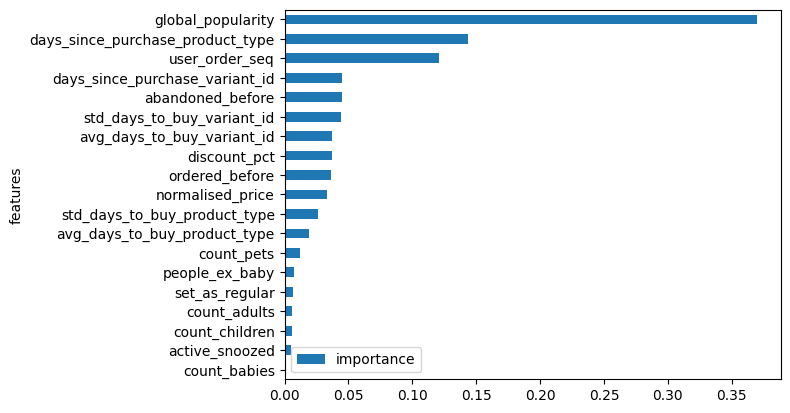

In [28]:
rf = RandomForestClassifier(100)
rf.fit(X_train[columns], y_train)

rf_fi, fig, ax = plot_feature_importance (rf, columns)

In [29]:
filtered_columns = rf_fi["features"].iloc[:15]

In [30]:
from sklearn.ensemble import RandomForestClassifier

n_trees_grid = [5, 25, 50, 100]

rf_push_train_aucs = []
rf_push_val_aucs = []

rf_push_train_ce = []
rf_push_val_ce = []

rf_push_train_aps = []
rf_push_val_aps = []

columns_to_use = filtered_columns
for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_train[columns_to_use], y_train)

    evaluate_configuration(
        rf,
        X_train[columns_to_use],
        y_train,
        X_val[columns_to_use],
        y_val,
        rf_push_train_aucs,
        rf_push_val_aucs,
        rf_push_train_ce,
        rf_push_val_ce,
        rf_push_train_aps,
        rf_push_val_aps,
    )

    print(
        f"# Trees: {n_trees} done with train auc: {rf_push_train_aucs[-1]:.4f} and val auc: {rf_push_val_aucs[-1]:.4f}. "
        f"AP train: {rf_push_train_aps[-1]:.4f} and val: {rf_push_val_aps[-1]:.4f}. "
        f"Cross entropy train: {rf_push_train_ce[-1]:.4f}, val: {rf_push_val_ce[-1]:.4f}."
    )

# Trees: 5 done with train auc: 0.8492 and val auc: 0.7661. AP train: 0.2499 and val: 0.1476. Cross entropy train: 0.0596, val: 0.0989.
# Trees: 25 done with train auc: 0.8500 and val auc: 0.7866. AP train: 0.2576 and val: 0.1576. Cross entropy train: 0.0592, val: 0.0838.
# Trees: 50 done with train auc: 0.8499 and val auc: 0.7914. AP train: 0.2585 and val: 0.1578. Cross entropy train: 0.0592, val: 0.0798.
# Trees: 100 done with train auc: 0.8500 and val auc: 0.7939. AP train: 0.2589 and val: 0.1595. Cross entropy train: 0.0592, val: 0.0772.



- Train being < 1 indicates that are samples that are identical in the input but with different output in different trees because of having less features:
    - This indicates that the data is either very noisy or we are missing relevant variables to make the prediction
    - Reducing columns have increased performance --> probably because we have decrease correlation of the trees dropping somewhat correlated features.
- We are far from Logistic Regression performance.

### Gradient boosting trees

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

n_trees_grid = [5, 25, 50, 100]

gbt_push_train_aucs = []
gbt_push_val_aucs = []

gbt_push_train_ce = []
gbt_push_val_ce = []

gbt_push_train_aps = []
gbt_push_val_aps = []

for lr in [0.05, 0.1]:
    for depth in [1, 3, 5]:
        for n_trees in n_trees_grid:
            gbt = GradientBoostingClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n_trees
            )
            gbt.fit(X_train[columns], y_train)

            evaluate_configuration(
                gbt,
                X_train[columns],
                y_train,
                X_val[columns],
                y_val,
                gbt_push_train_aucs,
                gbt_push_val_aucs,
                gbt_push_train_ce,
                gbt_push_val_ce,
                gbt_push_train_aps,
                gbt_push_val_aps
            )

            print(
                f"LR: {lr} max depth: {depth} trees: {n_trees} done with "
                f"train auc: {gbt_push_train_aucs[-1]:.4f} and val auc: {gbt_push_val_aucs[-1]:.4f} "
                f"AP train: {gbt_push_train_aps[-1]:.4f} and val: {gbt_push_val_aps[-1]:.4f} "
                f"Cross entropy train: {gbt_push_train_ce[-1]:.4f}, val: {gbt_push_val_ce[-1]:.4f}"
            )

LR: 0.05 max depth: 1 trees: 5 done with train auc: 0.6461 and val auc: 0.6543 AP train: 0.0909 and val: 0.0763 Cross entropy train: 0.0729, val: 0.0670
LR: 0.05 max depth: 1 trees: 25 done with train auc: 0.7680 and val auc: 0.7544 AP train: 0.1332 and val: 0.1214 Cross entropy train: 0.0691, val: 0.0635
LR: 0.05 max depth: 1 trees: 50 done with train auc: 0.8163 and val auc: 0.8109 AP train: 0.1554 and val: 0.1418 Cross entropy train: 0.0662, val: 0.0609
LR: 0.05 max depth: 1 trees: 100 done with train auc: 0.8300 and val auc: 0.8313 AP train: 0.1680 and val: 0.1628 Cross entropy train: 0.0644, val: 0.0586
LR: 0.05 max depth: 3 trees: 5 done with train auc: 0.7793 and val auc: 0.7677 AP train: 0.1516 and val: 0.1350 Cross entropy train: 0.0701, val: 0.0647
LR: 0.05 max depth: 3 trees: 25 done with train auc: 0.8221 and val auc: 0.8233 AP train: 0.1810 and val: 0.1719 Cross entropy train: 0.0650, val: 0.0592
LR: 0.05 max depth: 3 trees: 50 done with train auc: 0.8359 and val auc: 0.84

- Con Random Search tu pones las listas como parámetros, y prueba valores aleatorios de las listas (menos costoso pero más probable no encontrar la mejor combinación)
- Miro en el output para sacar las variables con el AP (Average Precision Score) en val más alto: 0.19

In [32]:
best_learning_rate = 0.05
best_max_depth = 5
best_n_trees = 50

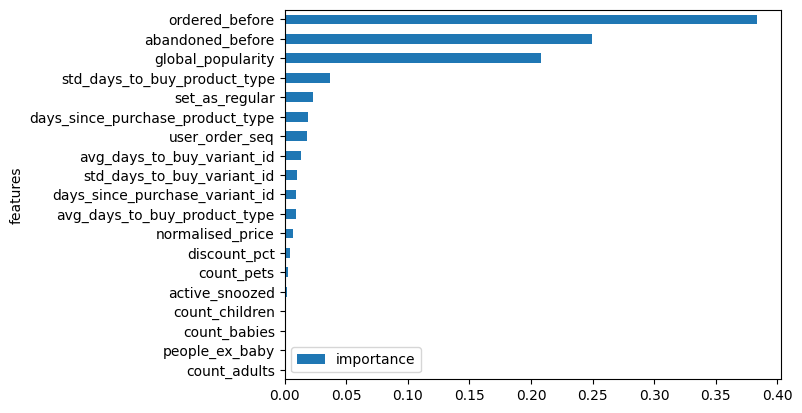

In [33]:
gbt = GradientBoostingClassifier(
    learning_rate=best_learning_rate, max_depth=best_max_depth, n_estimators=best_n_trees
)
gbt.fit(X_train[columns], y_train)
gbt_fi, fig, ax = plot_feature_importance(gbt, columns)

In [34]:
gbt_columns = (
    gbt_fi.loc[gbt_fi["importance"] > 0]
    .sort_values(by="importance", ascending=False)["features"]
    .tolist()
)
gbt_columns = gbt_columns[:15]  # Seleccionar las 15 características más importantes

In [35]:
gbt_push_train_aucs = []
gbt_push_val_aucs = []

gbt_push_train_ce = []
gbt_push_val_ce = []

gbt_push_train_aps = []
gbt_push_val_aps = []

for i in range(1, len(gbt_columns) + 1):
    gbt = GradientBoostingClassifier(
        learning_rate=best_learning_rate, max_depth=best_max_depth, n_estimators=best_n_trees
    )
    columns_to_use = gbt_columns[:i]
    gbt.fit(X_train[columns_to_use], y_train)

    evaluate_configuration(
        gbt,
        X_train[columns_to_use],
        y_train,
        X_val[columns_to_use],
        y_val,
        gbt_push_train_aucs,
        gbt_push_val_aucs,
        gbt_push_train_ce,
        gbt_push_val_ce,
        gbt_push_train_aps,
        gbt_push_val_aps,
    )

    print(
        f"LR: {best_learning_rate} max depth: {best_max_depth} trees: {best_n_trees} done with "
        f"train aug: {gbt_push_train_aucs[-1]:.4f} and val aug: {gbt_push_val_aucs[-1]:.4f} "
        f"AP train: {gbt_push_train_aps[-1]:.4f} and val: {gbt_push_val_aps[-1]:.4f} "
        f"Cross entropy train: {gbt_push_train_ce[-1]:.4f}, val: {gbt_push_val_ce[-1]:.4f}"
    )

LR: 0.05 max depth: 5 trees: 50 done with train aug: 0.6278 and val aug: 0.6484 AP train: 0.0546 and val: 0.0658 Cross entropy train: 0.0714, val: 0.0638
LR: 0.05 max depth: 5 trees: 50 done with train aug: 0.6461 and val aug: 0.6543 AP train: 0.0954 and val: 0.0783 Cross entropy train: 0.0691, val: 0.0631
LR: 0.05 max depth: 5 trees: 50 done with train aug: 0.8352 and val aug: 0.8351 AP train: 0.1810 and val: 0.1617 Cross entropy train: 0.0627, val: 0.0576
LR: 0.05 max depth: 5 trees: 50 done with train aug: 0.8361 and val aug: 0.8361 AP train: 0.1906 and val: 0.1740 Cross entropy train: 0.0626, val: 0.0573
LR: 0.05 max depth: 5 trees: 50 done with train aug: 0.8376 and val aug: 0.8424 AP train: 0.1952 and val: 0.1863 Cross entropy train: 0.0624, val: 0.0564
LR: 0.05 max depth: 5 trees: 50 done with train aug: 0.8392 and val aug: 0.8439 AP train: 0.1997 and val: 0.1879 Cross entropy train: 0.0622, val: 0.0563
LR: 0.05 max depth: 5 trees: 50 done with train aug: 0.8395 and val aug: 0.8

- What about other gradient boosting trees implementations like CatBoost or XGBoost? While they might be interesting to check their results, especially CatBoost for its native compatibility with categorical features, our goal here was to focus on the common process of training and evaluation and compare some models, not going in depth into each potential model.

- What about K-nearest neighbor? This classifier would NOT be suitable in this case since it requires a huge amount of computation time during inference, as it computes the distance to all training points for each inference. Given our dataset size, it is impracticable.

- What about SVMs? For large datasets, SVMs are tremendously slow to fit and are not the best for outputting probabilities, which is convenient for adapting our threshold in imbalanced datasets to adjust precision-recall. We are not going for it. If, as a student, you are willing to play around, remember that selecting features is important for SVMs and explore how the regularization parameter C and kernel parameters affect:

svm_regressor=make_pipeline(StandardScaler(), SVC(C=c,gamma=gamma,kernel=′rbf′))
svm_regressor.fit(X_train.loc[:,columns],y_train)

- What about Neural networks? They tend not to be the best for tabular data. In the interest of time, we are not doing them here since they also require dealing with other packages like TensorFlow or PyTorch. It would make sense as a student to explore different architectures (number of layers and neurons), train with cross-entropy or weighted cross-entropy, and test different regularization levels as we did in logistic regression.

#### Comparing our models

In [36]:
def get_summary_metrics(y_true, y_pred):
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    
    return precision, recall, pr_thresholds, fpr, tpr, roc_thresholds, auc, ap

In [37]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train[filtered_columns], y_train)
rf_predictions = rf.predict_proba(X_val[filtered_columns])[:, 1]
print("RF all columns trained")

rf_all = RandomForestClassifier(n_estimators=100)
rf_all.fit(X_train[columns], y_train)
rf_all_predictions = rf_all.predict_proba(X_val[columns])[:, 1]
print("RF filtered columns trained")

gbt = GradientBoostingClassifier(
    learning_rate=best_learning_rate, max_depth=best_max_depth, n_estimators=best_n_trees
)
gbt.fit(X_train[gbt_columns], y_train)
gbt_predictions = gbt.predict_proba(X_val[gbt_columns])[:, 1]
print("GBT trained")

lr = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="l2", C=1e-4, solver="saga")
)
lr.fit(X_train[reduced_cols], y_train)
lr_predictions = lr.predict_proba(X_val[reduced_cols])[:, 1]
print("Logistic regression trained")

RF all columns trained
RF filtered columns trained
GBT trained
Logistic regression trained


In [38]:
(
    rf_push_precision,
    rf_push_recall,
    rf_push_pr_thresholds,
    rf_push_fpr,
    rf_push_tpr,
    rf_push_roc_thresholds,
    rf_push_auc,
    rf_push_ap,
) = get_summary_metrics(y_val, rf_predictions)

(
    rf_all_push_precision,
    rf_all_push_recall,
    rf_all_push_pr_thresholds,
    rf_all_push_fpr,
    rf_all_push_tpr,
    rf_all_push_roc_thresholds,
    rf_all_push_auc,
    rf_all_push_ap,
) = get_summary_metrics(y_val, rf_all_predictions)

(
    gbt_push_precision,
    gbt_push_recall,
    gbt_push_pr_thresholds,
    gbt_push_fpr,
    gbt_push_tpr,
    gbt_push_roc_thresholds,
    gbt_push_auc,
    gbt_push_ap,
) = get_summary_metrics(y_val, gbt_predictions)

(
    lr_push_precision,
    lr_push_recall,
    lr_push_pr_thresholds,
    lr_push_fpr,
    lr_push_tpr,
    lr_push_roc_thresholds,
    lr_push_auc,
    lr_push_ap,
) = get_summary_metrics(y_val, lr_predictions)

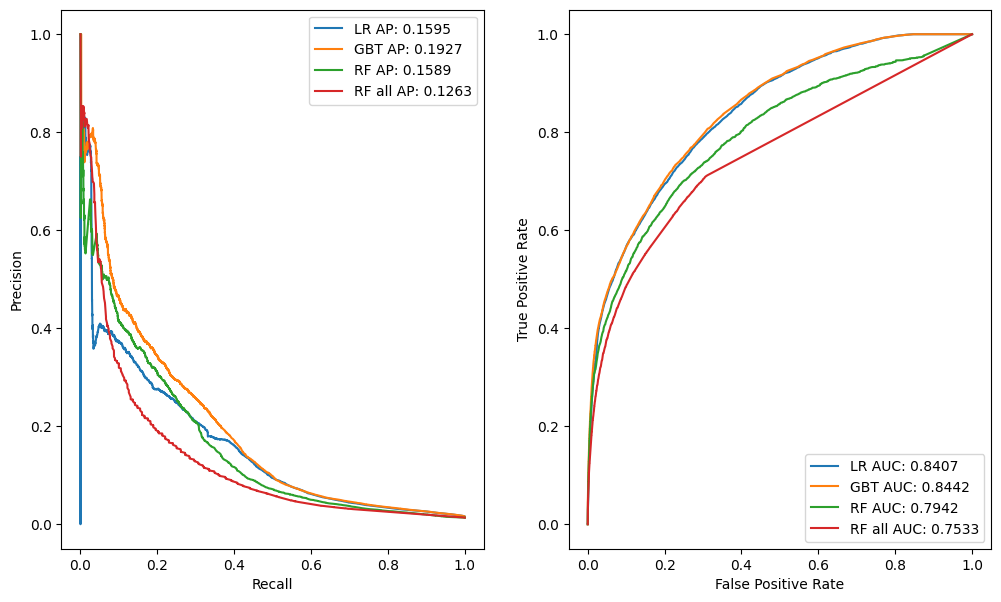

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].plot(lr_push_recall, lr_push_precision, label=f'LR AP: {lr_push_ap:.4f}')
ax[0].plot(gbt_push_recall, gbt_push_precision, label=f'GBT AP: {gbt_push_ap:.4f}')
ax[0].plot(rf_push_recall, rf_push_precision, label=f'RF AP: {rf_push_ap:.4f}')
ax[0].plot(rf_all_push_recall, rf_all_push_precision, label=f'RF all AP: {rf_all_push_ap:.4f}')
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].legend()

ax[1].plot(lr_push_fpr, lr_push_tpr, label=f'LR AUC: {lr_push_auc:.4f}')
ax[1].plot(gbt_push_fpr, gbt_push_tpr, label=f'GBT AUC: {gbt_push_auc:.4f}')
ax[1].plot(rf_push_fpr, rf_push_tpr, label=f'RF AUC: {rf_push_auc:.4f}')
ax[1].plot(rf_all_push_fpr, rf_all_push_tpr, label=f'RF all AUC: {rf_all_push_auc:.4f}')
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

plt.show()


- Logistic regression and Gradient Boosting trees are being the best and we will only be focusing on them from now.
- Precision recall curve: Orange is the best in all points. Between blue and green, green is better in most of the points.
- For colour blind people, don't use red and green, use red and blue (palettes or continous and non continuous line).
- Where we want to work? In the ideal work we want for every recall point we gain, lose less than a point of precision.


#### What point to choose from the AUC and AP?
- This question should be answer along with business, like how costly is to miss users (lower recall) vs how costly is to bother a user with an unwanted push notification (lower precision).
- Nevertheless, we can use the information coming from the PRD that "about 5% of push notifications" are opened. Let's assume that if a user is interested in the product he will open the push. Therefore, we can target those with a probability of interest higher than 5% to start beating the prevalance. Can we do this with our current model?

#### Calibration

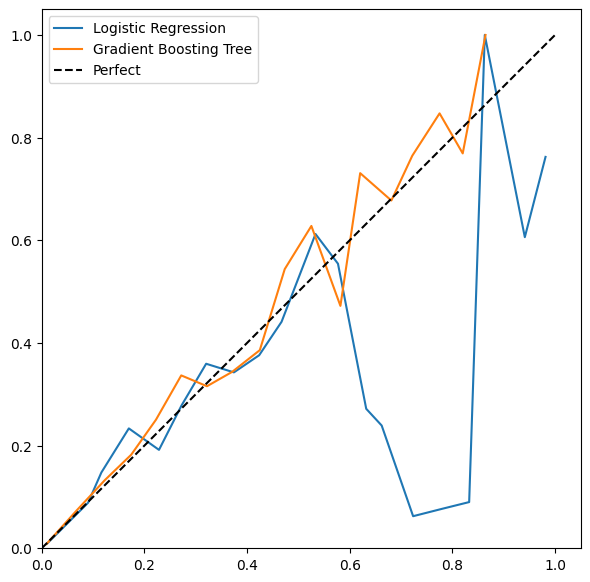

In [40]:
lr_prob_true, lr_prob_pred = calibration_curve(y_val, lr_predictions, n_bins=20)
gbt_prob_true, gbt_prob_pred = calibration_curve(y_val, gbt_predictions, n_bins=20)

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(lr_prob_pred, lr_prob_true, label="Logistic Regression")
ax.plot(gbt_prob_pred, gbt_prob_true, label="Gradient Boosting Tree")
ax.plot([0, 1], [0, 1], color="k", linestyle="--", label="Perfect")
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 1.05)
ax.set_aspect("equal", "box")
ax.legend()

- GBT is much better calibrated, because in LR for 0.55 there are only a few of 1.

In [41]:
calibrated_lr = CalibratedClassifierCV(lr, cv="prefit", method="isotonic")

calibrated_gbt = CalibratedClassifierCV(gbt, cv="prefit", method="isotonic")

- Usamos un modelo detrás de nuestro modelo para intentar corregir la curva.

In [42]:
calibrated_lr.fit(X_val[reduced_cols], y_val)
val_lr_calibrated_pred = calibrated_lr.predict_proba(X_val[reduced_cols])[:, 1]
test_lr_calibrated_pred = calibrated_lr.predict_proba(X_test[reduced_cols])[:, 1]

calibrated_gbt.fit(X_val[gbt_columns], y_val)
val_gbt_calibrated_pred = calibrated_gbt.predict_proba(X_val[gbt_columns])[:, 1]
test_gbt_calibrated_pred = calibrated_gbt.predict_proba(X_test[gbt_columns])[:, 1]

In [43]:
lr_prob_true_val_calibrated, lr_prob_pred_val_calibrated = calibration_curve(
    y_val, val_lr_calibrated_pred, n_bins=20
)

lr_prob_true_test_calibrated, lr_prob_pred_test_calibrated = calibration_curve(
    y_test, test_lr_calibrated_pred, n_bins=20
)

gbt_prob_true_val_calibrated, gbt_prob_pred_val_calibrated = calibration_curve(
    y_val, val_gbt_calibrated_pred, n_bins=20
)

gbt_prob_true_test_calibrated, gbt_prob_pred_test_calibrated = calibration_curve(
    y_test, test_gbt_calibrated_pred, n_bins=20
)

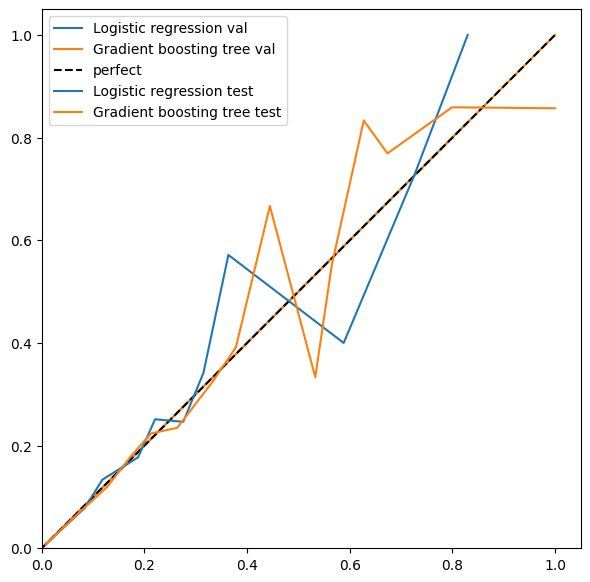

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(
    lr_prob_pred_val_calibrated,
    lr_prob_true_val_calibrated,
    label="Logistic regression val",
    color="C0",
    linestyle="-"
)

ax.plot(
    gbt_prob_pred_val_calibrated,
    gbt_prob_true_val_calibrated,
    label="Gradient boosting tree val",
    color="C1",
    linestyle="-"
)

ax.plot([0, 1], [0, 1], color="k", linestyle="--", label="perfect")

ax.plot(
    lr_prob_pred_test_calibrated,
    lr_prob_true_test_calibrated,
    label="Logistic regression test",
    color="C0"
)

ax.plot(
    gbt_prob_pred_test_calibrated,
    gbt_prob_true_test_calibrated,
    label="Gradient boosting tree test",
    color="C1"
)

ax.set_ylim(0, 1.05)
ax.set_xlim(0, 1.05)
ax.set_aspect("equal", "box")
ax.legend()


- GBT still better calibrated.
- Calibration still far from perfect but better than uncalibrated model

#### Asessing final performance

In [45]:
threshold = 0.05

gbt_test_binary_pred = (test_gbt_calibrated_pred > threshold).astype(int)
lr_test_binary_pred = (test_lr_calibrated_pred > threshold).astype(int)

In [46]:
def get_model_binary_metrics(y_true, y_pred, name=""):
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    results = pd.Series(
        {
            "precision": precision[1],
            "recall": recall[1],
            "f1": f1[1],
            "prevalence": support[1] / (support[0] + support[1]),
        },
        name=name,
    )
    return results

In [47]:

gbt_test_results = get_model_binary_metrics(y_test, gbt_test_binary_pred, name="gbt")
lr_test_results = get_model_binary_metrics(y_test, lr_test_binary_pred, name="lr")

test_results = pd.concat([gbt_test_results, lr_test_results], axis=1)
test_results

,gbt,lr
precision,0.155879,0.148812
recall,0.406840,0.406250
f1,0.225398,0.217831
prevalence,0.012874,0.012874


- Comparamos con ese threshold de 0.05, y del 1% de aperturas en prevalence, tenemos una precisión del 15% y una recall del 40%

In [48]:
(
    lr_push_precision,
    lr_push_recall,
    lr_push_pr_thresholds,
    lr_push_fpr,
    lr_push_tpr,
    lr_push_roc_thresholds,
    lr_push_auc,
    lr_push_auc_ap,
) = get_summary_metrics(y_test, test_lr_calibrated_pred)

(
    gbt_push_precision,
    gbt_push_recall,
    gbt_push_pr_thresholds,
    gbt_push_fpr,
    gbt_push_tpr,
    gbt_push_roc_thresholds,
    gbt_push_auc,
    gbt_push_auc_ap,
) = get_summary_metrics(y_test, test_gbt_calibrated_pred)

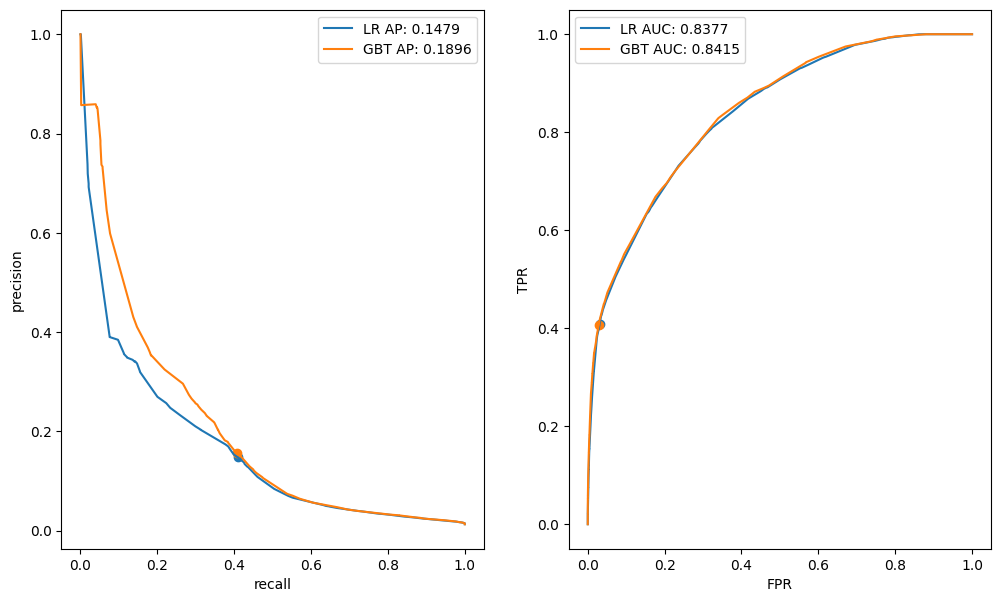

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

lr_pr_th = np.argmin(np.abs(lr_push_pr_thresholds - threshold))
gbt_pr_th = np.argmin(np.abs(gbt_push_pr_thresholds - threshold))

lr_roc_th = np.argmin(np.abs(lr_push_roc_thresholds - threshold))
gbt_roc_th = np.argmin(np.abs(gbt_push_roc_thresholds - threshold))

ax[0].plot(lr_push_recall, lr_push_precision, label=f"LR AP: {lr_push_auc_ap:.4f}")
ax[0].plot(gbt_push_recall, gbt_push_precision, label=f"GBT AP: {gbt_push_auc_ap:.4f}")

ax[0].scatter(
    lr_push_recall[lr_pr_th], lr_push_precision[lr_pr_th], label=None, color="C0"
)
ax[0].scatter(
    gbt_push_recall[gbt_pr_th], gbt_push_precision[gbt_pr_th], label=None, color="C1"
)

ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")

ax[1].plot(lr_push_fpr, lr_push_tpr, label=f"LR AUC: {lr_push_auc:.4f}")
ax[1].plot(gbt_push_fpr, gbt_push_tpr, label=f"GBT AUC: {gbt_push_auc:.4f}")

ax[1].scatter(
    lr_push_fpr[lr_roc_th], lr_push_tpr[lr_roc_th], label=None, color="C0"
)
ax[1].scatter(
    gbt_push_fpr[gbt_roc_th], gbt_push_tpr[gbt_roc_th], label=None, color="C1"
)

ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")

ax[0].legend()
ax[1].legend()


- Ambos modelos funcionan mejor que el baseline.
- Los puntos son el punto donde trabajamos, que es el 0.05 del modelo calibrado.

#### Checking new users only

In [50]:
train_users = X_train["user_id"].unique()
val_users = X_val["user_id"].unique()
test_users = X_test["user_id"].unique()

train_val_users = np.union1d(train_users, val_users)

new_test_users = np.setdiff1d(test_users, train_val_users)

old_test_users = np.intersect1d(test_users, train_val_users)

In [51]:
new_test_users_mask = X_test['user_id'].isin(new_test_users).values
old_test_users_mask = X_test['user_id'].isin(old_test_users).values

In [52]:
gbt_new_users_test_results = get_model_binary_metrics(
    y_test[new_test_users_mask],
    gbt_test_binary_pred[new_test_users_mask],
    name="gbt",
)

lr_new_users_test_results = get_model_binary_metrics(
    y_test[new_test_users_mask],
    lr_test_binary_pred[new_test_users_mask],
    name="lp",
)

test_new_users_results = pd.concat(
    [gbt_new_users_test_results, lr_new_users_test_results], axis=1
)
test_new_users_results

,gbt,lp
precision,0.164427,0.158683
recall,0.335864,0.340537
f1,0.220772,0.216487
prevalence,0.012004,0.012004


In [53]:
gbt_old_users_test_results = get_model_binary_metrics(
    y_test[old_test_users_mask],
    gbt_test_binary_pred[old_test_users_mask],
    name="gbt",
)

lr_old_users_test_results = get_model_binary_metrics(
    y_test[old_test_users_mask],
    lr_test_binary_pred[old_test_users_mask],
    name="lr",
)

test_old_users_results = pd.concat(
    [gbt_old_users_test_results, lr_old_users_test_results], axis=1
)
test_old_users_results

,gbt,lr
precision,0.150299,0.142320
recall,0.479167,0.473214
f1,0.228823,0.218827
prevalence,0.013901,0.013901



New users have a lower f1 score. Interesting the precision drops for old users but the recall skyrockets

#### Outcome


We have seen that:
- Gradient boosting trees are the best performant model
- Logistic regression while simple is a good contender in this dataset
- L1 and L2 regularisations outputs different coefficients, being L1 more sparse.
- Regularisation helps with model performance
- Sometimes removing correlated or low power columns in Random Forest helps with performance
- Callibration can be useful for our business case. It must be done with a different dataset than training to avoid bias.
- We have used class imbalance robust metrics like AUC and AP.
- We have used temporal split since the business is growing a lot and probably data is not stable over time.
What about? What about categorical features? We have left this out since we were focus on the model training step, but it can be interesting to check how they affect performance. There exist several ways to encode them to use in our models or we can use models like Catboost that can work with them natively.
What about? What about using Cross validation for hyperparameter tuning? It could have been an option. However, since we observed the temporal component in the data we must be careful. Classes like sklearn.model_selection.GridSearchCV could have been used if we were going for CrossValidation. Does regular CV cause any problem? You are also suggested to use sklearn.model_selection. StratifiedGroupKFold, could you challenge that suggestion or give arguments in its favour?